### Import required packages and functions

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
from scipy.stats import skew, kurtosis
from pandas.tseries.offsets import CustomBusinessDay
from pandas.tseries.holiday import USFederalHolidayCalendar
import pandas_datareader.data as web
import warnings
import functions_part_II
warnings.filterwarnings("ignore")
from functions_part_II import delta_hedging, calendar_to_business_days, create_straddles, process_straddles, dp_hedging_collect_training_data, train_random_forest_model, apply_hedging_model, get_feature_importance, plot_feature_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [34]:
import importlib
importlib.reload(functions_part_II)

<module 'functions_part_II' from 'c:\\Users\\benj0\\OneDrive - HEC Montréal\\Desktop\\Straddle_hedging_project\\functions_part_II.py'>

### Initialize important dates

In [2]:
start_date = '2007-01-01'
end_date = '2023-09-30'

training_start_date = '2007-01-01'
training_end_date = '2015-12-31'
test_start_date = '2016-01-01'
test_end_date = '2023-08-31'

### Fetch and Process S&P prices data

In [3]:
sp = yf.download('^SPX')

sp.index = pd.to_datetime(sp.index)

# Filter the DataFrame
filtered_sp = sp.loc[start_date:end_date]

# Remove the ticker level from the multi index
filtered_sp.columns = filtered_sp.columns.droplevel(1)
filtered_sp = pd.DataFrame(filtered_sp['Close'], index=filtered_sp.index)
filtered_sp.index = pd.to_datetime(filtered_sp.index).tz_localize(None)

[*********************100%***********************]  1 of 1 completed


### Fetch and Process Fama French Risk free rate data

In [4]:
# Fetch the Fama-French 3-factor data
ff_data = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start_date, end_date)

# Convert period index to datetime
rf_data = ff_data[0]  # Extract the first dataframe (RF)
rf_data.index = rf_data.index.to_timestamp()  

# Select the RF column (risk-free rate)
risk_free_rate = pd.DataFrame(rf_data['RF'])

# Resample to daily frequency, forward-fill missing values (public holidays), and annualize the risk free rate
risk_free_rate = risk_free_rate.resample('D').ffill()
risk_free_rate = risk_free_rate * 12 / 100

### Reindex data to forward fill prices and risk free for public holidays

In [5]:
market_df = filtered_sp.merge(risk_free_rate, left_index=True, right_index=True)

# Create a new business day index
new_index = pd.bdate_range(start=start_date, end=end_date)

# Create a new DataFrame with the business day index
real_market_df = pd.DataFrame(index=new_index)

# Merge the existing market_df with the new DataFrame
real_market_df = real_market_df.merge(market_df, left_index=True, right_index=True, how='left')

# Forward fill the missing values
real_market_df.ffill(inplace=True)

# Rename the index to 'Date' if necessary
real_market_df.index.name = 'Date'

# Display the updated DataFrame
real_market_df

,Close,RF
Date,,
2007-01-01,NaN,NaN
2007-01-02,NaN,NaN
2007-01-03,1416.599976,0.0528
2007-01-04,1418.339966,0.0528
2007-01-05,1409.709961,0.0528
...,...,...
2023-09-25,4515.770020,0.0516
2023-09-26,4515.770020,0.0516
2023-09-27,4515.770020,0.0516


### Read Option data

In [6]:
# Read data from CSV
data = pd.read_csv('filtered_data_cleaned.csv')
data.set_index('Date', inplace=True)

### Define training and testing data

In [7]:
data_train = data[training_start_date:training_end_date]
option_df_train = data_train
data_train.index = pd.to_datetime(data_train.index)

data_test = data[test_start_date:test_end_date]
option_df_test = data_test
data_test.index = pd.to_datetime(data_test.index)

### Compute MidPrice and convert calendar days to business days

In [8]:
# Get midprice for all data
data_train['Midprice'] = (data_train['best_bid'] + data_train['best_offer']) / 2
data_test['Midprice'] = (data_test['best_bid'] + data_test['best_offer']) / 2

# convert calendar to business days
option_df_train['Business_Days_to_Expiration'] = option_df_train.apply(lambda row: calendar_to_business_days(row.name, row['exdate'], row['D to Expiration']), axis=1)
option_df_test['Business_Days_to_Expiration'] = option_df_test.apply(lambda row: calendar_to_business_days(row.name, row['exdate'], row['D to Expiration']), axis=1)

### Keep only options with 1 month or more to maturity

In [9]:
data_1m_train = data_train[data_train['Business_Days_to_Expiration'] >= 22]
data_1m_train.index = pd.to_datetime(data_1m_train.index)

data_1m_test = data_test[data_test['Business_Days_to_Expiration'] >= 22]
data_1m_test.index = pd.to_datetime(data_1m_test.index)

### Create Straddles for each dates

In [10]:
# Group the data by date, strike price, and expiration date
groups_train = data_1m_train.groupby(['Date', 'strike_price', 'Business_Days_to_Expiration'])
groups_test = data_1m_test.groupby(['Date', 'strike_price', 'Business_Days_to_Expiration'])

straddles_df_train = create_straddles(groups_train)
straddles_df_test = create_straddles(groups_test)

### If the straddle starts later than 10th of the month, remove it to comply with the requirement that we choose a straddle at the "beginning" of the month

In [11]:
for dates in straddles_df_train.index:
    if dates.day > 10:
        straddles_df_train.drop(dates, inplace=True, errors='ignore')

for dates in straddles_df_test.index:
    if dates.day > 10:
        straddles_df_test.drop(dates, inplace=True, errors='ignore')

### For each month, choose only one straddle, the one with a moneyness closest to 1

In [12]:
first_straddles_monthly_train = process_straddles(straddles_df_train)
first_straddles_monthly_test = process_straddles(straddles_df_test)

### Apply delta hedging to train and test data, with and without transaction costs

In [13]:
# No transaction cost, training P&L
profit_no_cost_train = delta_hedging(first_straddles_monthly_train, option_df_train, real_market_df, transaction_cost=0)
profit_no_cost_train.set_index('Date', inplace=True)
profit_no_cost_train['Cumulative P&L'] = profit_no_cost_train['P&L'].cumsum()

In [14]:
# Transaction cost, testing P&L
profit_cost_train = delta_hedging(first_straddles_monthly_train, option_df_train, real_market_df, transaction_cost=0.005)
profit_cost_train.set_index('Date', inplace=True)
profit_cost_train['Cumulative P&L'] = profit_cost_train['P&L'].cumsum()

In [15]:
# No transaction cost, training P&L
profit_no_cost_test = delta_hedging(first_straddles_monthly_test, option_df_test, real_market_df, transaction_cost=0)
profit_no_cost_test.set_index('Date', inplace=True)
profit_no_cost_test['Cumulative P&L'] = profit_no_cost_test['P&L'].cumsum()
profit_no_cost_test

,Initial Value,Final Cash Value,Payoff,Hedging Error,P&L,Cumulative P&L
Date,,,,,,
2016-01-06,83.50,83.510379,109.949951,699.050987,-26.439572,-26.439572
2016-02-04,95.00,95.023291,107.189941,148.027371,-12.166650,-38.606222
2016-03-10,79.65,79.665468,90.729980,122.423439,-11.064513,-49.670735
2016-04-05,72.95,72.959369,1.609985,5090.734575,71.349384,21.678649
2016-05-04,66.45,66.457352,49.129883,300.241196,17.327469,39.006118
...,...,...,...,...,...,...
2023-04-06,173.75,174.563819,19.080078,24175.193697,155.483741,283.953363
2023-05-08,141.80,142.450138,158.859863,269.279072,-16.409725,267.543638
2023-06-08,108.60,109.156772,114.529785,28.869272,-5.373013,262.170625


In [16]:
# Transaction cost, testing P&L
profit_cost_test = delta_hedging(first_straddles_monthly_test, option_df_test, real_market_df, transaction_cost=0.005)
profit_cost_test.set_index('Date', inplace=True)
profit_cost_test['Cumulative P&L'] = profit_cost_test['P&L'].cumsum()
print(f"Tracking Error: {profit_cost_test['P&L'].std()}")
profit_cost_test

Tracking Error: 99.62706000252963


,Initial Value,Final Cash Value,Payoff,Hedging Error,P&L,Cumulative P&L
Date,,,,,,
2016-01-06,83.50,83.468310,109.949951,701.277338,-26.481642,-26.481642
2016-02-04,95.00,94.899783,107.189941,151.048004,-12.290159,-38.771800
2016-03-10,79.65,79.422018,90.729980,127.870026,-11.307963,-50.079763
2016-04-05,72.95,72.583347,1.609985,5037.218067,70.973362,20.893598
2016-05-04,66.45,66.202729,49.129883,291.482079,17.072846,37.966445
...,...,...,...,...,...,...
2023-04-06,173.75,173.010255,19.080078,23694.499253,153.930177,249.283946
2023-05-08,141.80,141.013588,158.859863,318.489558,-17.846276,231.437670
2023-06-08,108.60,106.853616,114.529785,58.923575,-7.676169,223.761501


### Plot the cumulative P&L of the test data

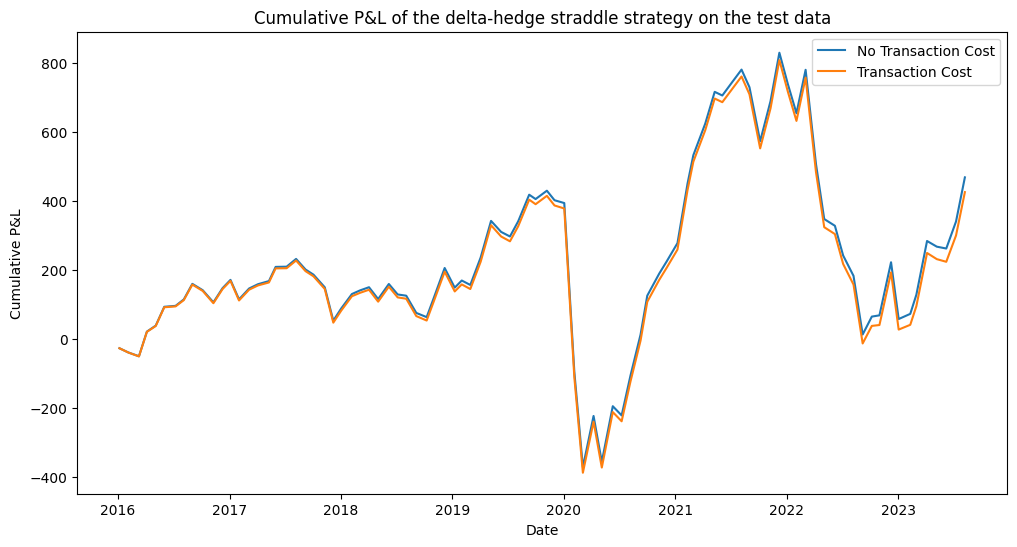

In [17]:
# Plot the cumulative P&L of the test data
plt.figure(figsize=(12, 6))
plt.plot(profit_no_cost_test['Cumulative P&L'], label='No Transaction Cost')
plt.plot(profit_cost_test['Cumulative P&L'], label='Transaction Cost')
plt.title('Cumulative P&L of the delta-hedge straddle strategy on the test data')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L')
plt.legend()
plt.show()

### Create training sample on daily straddles and monthly straddles

In [ ]:
print("Finding optimal phis on daily straddles...")
training_set_day = dp_hedging_collect_training_data(straddles_df_train, data_train, real_market_df)
training_set_day.set_index('Date', inplace=True)
print(f"Training data shape: {training_set_day.shape}")

Finding optimal phis on daily straddles...
Training data shape: (96035, 20)


In [19]:
print("Finding optimal phis on monthly straddles...")
training_set_month = dp_hedging_collect_training_data(first_straddles_monthly_train, data_train, real_market_df)
training_set_month.set_index('Date', inplace=True)
print(f"Training data shape: {training_set_month.shape}")

Finding optimal phis on monthly straddles...
Training data shape: (1878, 20)


### Train RF on both frequency datasets

In [20]:
print("Training random forest daily...")
rf_daily = train_random_forest_model(training_set_day)
print("Random forest model trained.")

Training random forest daily...
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Random forest model trained.


In [21]:
print("Training random forest monthly...")
rf_monthly = train_random_forest_model(training_set_month)
print("Random forest model trained.")

Training random forest monthly...
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Random forest model trained.


### Plot feature importance for both

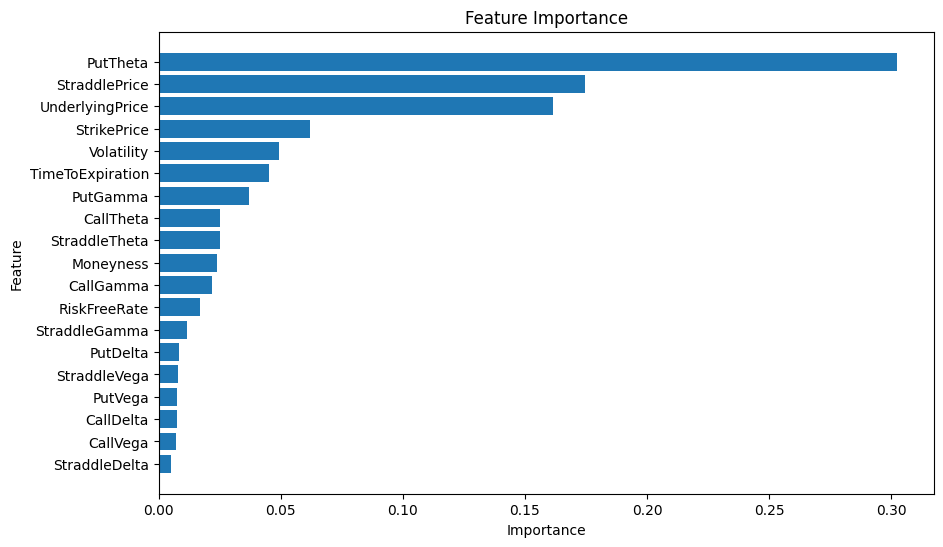

In [22]:
feature_names_day = training_set_day.drop(columns=['Phi']).columns.tolist()
feature_importance_day = get_feature_importance(rf_daily, feature_names_day)
# Plot feature importance
plot_feature_importance(feature_importance_day)

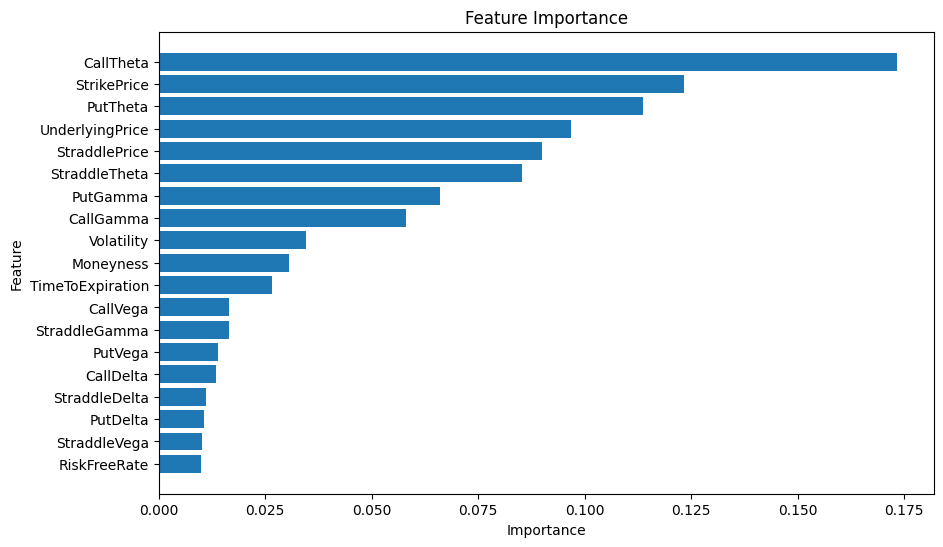

In [23]:
feature_names_month = training_set_month.drop(columns=['Phi']).columns.tolist()
feature_importance_month = get_feature_importance(rf_monthly, feature_names_month)
# Plot feature importance
plot_feature_importance(feature_importance_month)

### Apply hedging strategy to both

In [ ]:
print("Applying hedging model...")
results_df_daily = apply_hedging_model(
    first_straddles_monthly_test, 
    data_test, 
    real_market_df, 
    rf_daily, 
    transaction_cost=0.005
)

results_df_daily['Cumulative P&L'] = results_df_daily['P&L'].cumsum()
results_df_daily.set_index('StartDate', inplace=True)

results_df_daily

Applying hedging model...


,ExpirationDate,Initial Proceeds,Final Portfolio Value,Straddle Payoff,Hedging Error,P&L,Total Transaction Costs,Cumulative P&L
StartDate,,,,,,,,
2016-01-06,2016-02-05,83.50,84.446423,109.949951,650.429973,-25.503529,0.860898,-25.503529
2016-02-04,2016-03-11,95.00,93.372560,107.189941,190.920018,-13.817381,0.517315,-39.320910
2016-03-10,2016-04-15,79.65,78.655948,90.729980,145.782266,-12.074033,0.454789,-51.394942
2016-04-05,2016-05-13,72.95,72.847512,1.609985,5074.785244,71.237527,0.261430,19.842585
2016-05-04,2016-06-03,66.45,65.894936,49.129883,281.066992,16.765053,0.203346,36.607637
...,...,...,...,...,...,...,...,...
2023-04-06,2023-05-12,173.75,174.245336,19.080078,24076.257286,155.165258,0.277873,226.364137
2023-05-08,2023-06-09,141.80,140.641140,158.859863,331.921894,-18.218724,0.497428,208.145413
2023-06-08,2023-07-10,108.60,107.647546,114.529785,47.365219,-6.882239,0.853457,201.263174


In [ ]:
print("Applying hedging model...")
results_df_monthly = apply_hedging_model(
    first_straddles_monthly_test, 
    data_test, 
    real_market_df, 
    rf_monthly, 
    transaction_cost=0.005
)

results_df_monthly['Cumulative P&L'] = results_df_monthly['P&L'].cumsum()
results_df_monthly.set_index('StartDate', inplace=True)

results_df_monthly

Applying hedging model...


,ExpirationDate,Initial Proceeds,Final Portfolio Value,Straddle Payoff,Hedging Error,P&L,Total Transaction Costs,Cumulative P&L
StartDate,,,,,,,,
2016-01-06,2016-02-05,83.50,83.863432,109.949951,680.506506,-26.086520,0.794797,-26.086520
2016-02-04,2016-03-11,95.00,93.919546,107.189941,176.103385,-13.270395,0.449095,-39.356915
2016-03-10,2016-04-15,79.65,78.759760,90.729980,143.286189,-11.970221,0.575182,-51.327136
2016-04-05,2016-05-13,72.95,72.779289,1.609985,5065.069825,71.169304,0.264191,19.842168
2016-05-04,2016-06-03,66.45,65.937693,49.129883,282.502491,16.807810,0.212486,36.649979
...,...,...,...,...,...,...,...,...
2023-04-06,2023-05-12,173.75,174.221356,19.080078,24068.816193,155.141278,0.362737,231.580231
2023-05-08,2023-06-09,141.80,141.835652,158.859863,289.823771,-17.024211,0.335471,214.556020
2023-06-08,2023-07-10,108.60,108.376306,114.529785,37.865302,-6.153479,0.689132,208.402541


### Compare both P&Ls

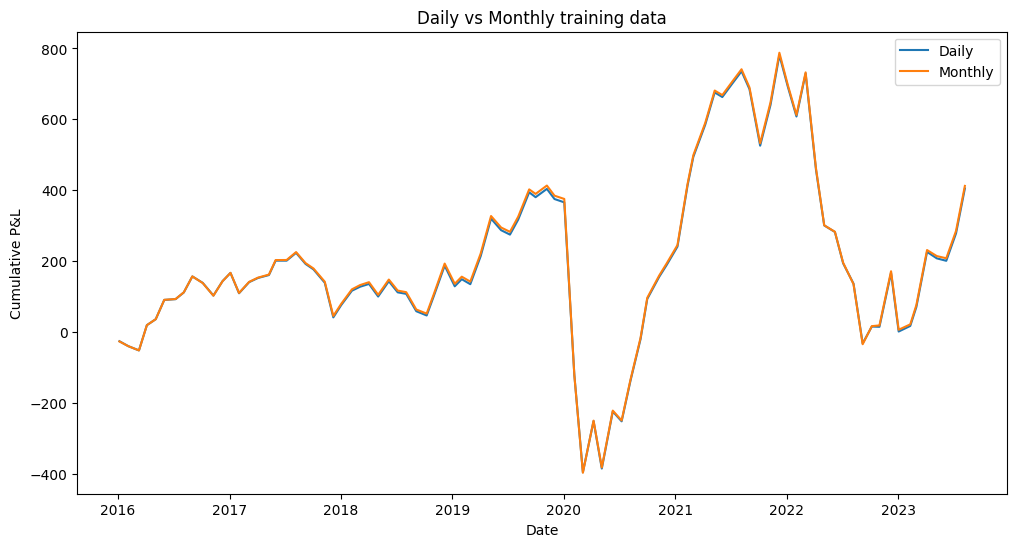

In [37]:
# Plot the cumulative P&L of the test data
plt.figure(figsize=(12, 6))
plt.plot(results_df_daily['Cumulative P&L'], label='Daily')
plt.plot(results_df_monthly['Cumulative P&L'], label='Monthly')
plt.title('Daily vs Monthly training data')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L')
plt.legend()
plt.show()

### Several plots to compare the three strategies

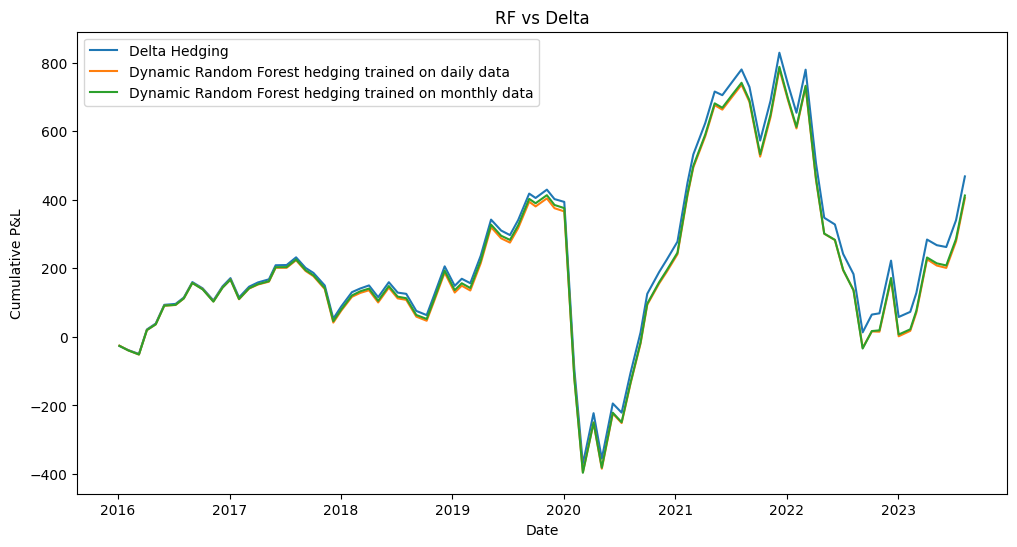

In [44]:
# Plot the cumulative P&L of the test data
plt.figure(figsize=(12, 6))
plt.plot(profit_no_cost_test['Cumulative P&L'], label='Delta Hedging')
plt.plot(results_df_daily['Cumulative P&L'], label='Dynamic Random Forest hedging trained on daily data')
plt.plot(results_df_monthly['Cumulative P&L'], label='Dynamic Random Forest hedging trained on monthly data')
plt.title('RF vs Delta')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L')
plt.legend()
plt.show()

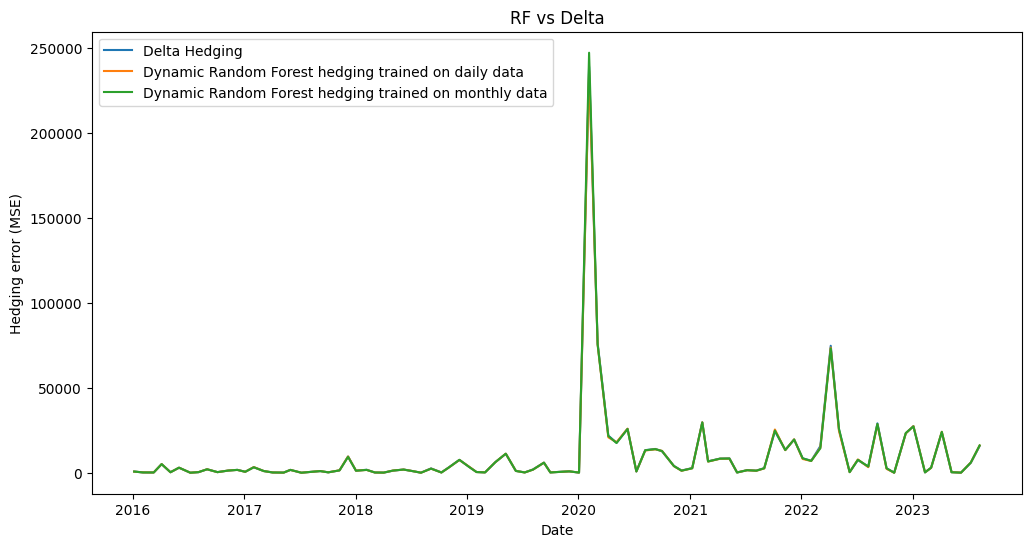

In [45]:
# Plot the hedging errors
plt.figure(figsize=(12, 6))
plt.plot(profit_cost_test['Hedging Error'], label='Delta Hedging')
plt.plot(results_df_daily['Hedging Error'], label='Dynamic Random Forest hedging trained on daily data')
plt.plot(results_df_monthly['Hedging Error'], label='Dynamic Random Forest hedging trained on monthly data')
plt.title('RF vs Delta')
plt.xlabel('Date')
plt.ylabel('Hedging error (MSE)')
plt.legend()
plt.show()

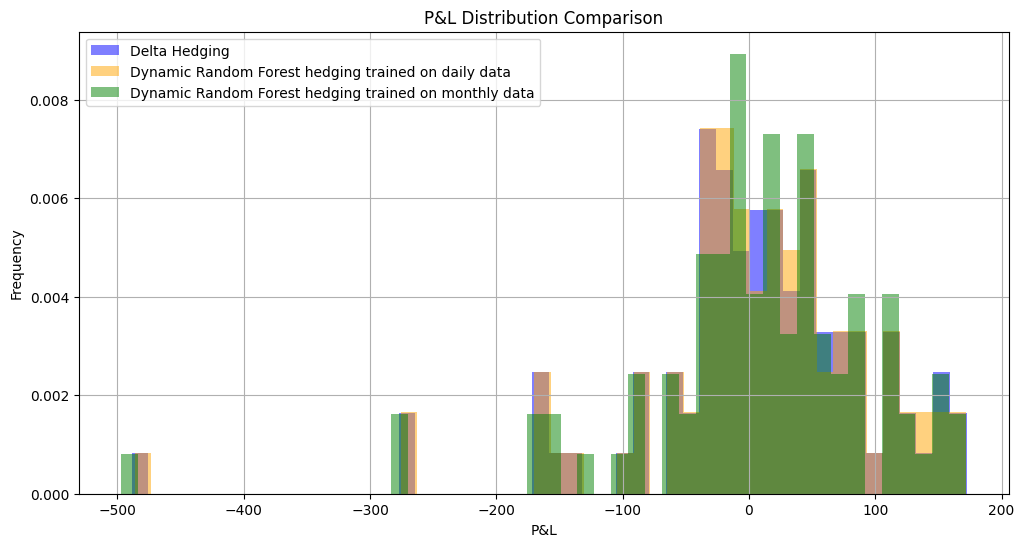

In [46]:
# Plot histograms for P&L distributions
plt.figure(figsize=(12, 6))

# Histogram for delta hedging model
plt.hist(profit_cost_test['P&L'], bins=50, alpha=0.5, label='Delta Hedging', color='blue', density=True)

# Histogram for the other model
plt.hist(results_df_daily['P&L'], bins=50, alpha=0.5, label='Dynamic Random Forest hedging trained on daily data', color='orange', density=True)

# Histogram for the other model
plt.hist(results_df_monthly['P&L'], bins=50, alpha=0.5, label='Dynamic Random Forest hedging trained on monthly data', color='green', density=True)

# Add titles and labels
plt.title('P&L Distribution Comparison')
plt.xlabel('P&L')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Moments

In [51]:
# Calculate statistical measures for delta hedging model
mean_delta_hedging = profit_cost_test['P&L'].mean()
median_delta_hedging = profit_cost_test['P&L'].median()
std_delta_hedging = profit_cost_test['P&L'].std()
skewness_delta_hedging = skew(profit_cost_test['P&L'])
kurtosis_delta_hedging = kurtosis(profit_cost_test['P&L'])

# Calculate statistical measures for the other model
mean_other_model_daily = results_df_daily['P&L'].mean()
median_other_model_daily = results_df_daily['P&L'].median()
std_other_model_daily = results_df_daily['P&L'].std()
skewness_other_model_daily = skew(results_df_daily['P&L'])
kurtosis_other_model_daily = kurtosis(results_df_daily['P&L'])

# Calculate statistical measures for the other model
mean_other_model_monthly = results_df_monthly['P&L'].mean()
median_other_model_monthly = results_df_monthly['P&L'].median()
std_other_model_monthly = results_df_monthly['P&L'].std()
skewness_other_model_monthly = skew(results_df_monthly['P&L'])
kurtosis_other_model_monthly = kurtosis(results_df_monthly['P&L'])

# Print the results
print("Delta Hedging Model:")
print(f"Mean: {mean_delta_hedging}")
print(f"Median: {median_delta_hedging}")
print(f"Standard Deviation: {std_delta_hedging}")
print(f"Skewness: {skewness_delta_hedging}")
print(f"Kurtosis: {kurtosis_delta_hedging}")

print("\nDynamic RF trained on daily data:")
print(f"Mean : {mean_other_model_daily}")
print(f"Median : {median_other_model_daily}")
print(f"Standard Deviation : {std_other_model_daily}")
print(f"Skewness : {skewness_other_model_daily}")
print(f"Kurtosis : {kurtosis_other_model_daily}")

print("\nDynamic RF trained on monthly data:")
print(f"Mean : {mean_other_model_monthly}")
print(f"Median : {median_other_model_monthly}")
print(f"Standard Deviation : {std_other_model_monthly}")
print(f"Skewness : {skewness_other_model_monthly}")
print(f"Kurtosis : {kurtosis_other_model_monthly}")

Delta Hedging Model:
Mean: 4.6233622566606165
Median: 11.131225870380202
Standard Deviation: 99.62706000252963
Skewness: -1.7285171947584541
Kurtosis: 6.0192037882497935

Dynamic RF trained on daily data:
Mean : 4.403772842009157
Median : 11.536355520200132
Standard Deviation : 99.22139849348359
Skewness : -1.7170770947057699
Kurtosis : 5.9783887892621905

Dynamic RF trained on monthly data:
Mean : 4.482782278216978
Median : 12.00893903781855
Standard Deviation : 99.87666439375442
Skewness : -1.7709250697247736
Kurtosis : 6.334536565666925


In [43]:
### HIGHER KURTOSIS = FATTER TAILS (EVEN THOUGH MARGINAL)
### MORE NEGATIVE SKEWNESS = LONGER LEFT TAIL -> HIGHER FREQUENCY OF NEGATIVE RETURNS